# Exploring lightning prediction setup

This notebook gets a set of grids and plots them to make sure we are pulling out training data correctly.
Read the [design doc](https://docs.google.com/document/d/1wmJN6G2f74aOZrqm2FJEkoeIQ_bvPz58FdAZr5SqSOk/edit) for more details.

In [2]:
%pip install --quiet --upgrade retrying pyresample netcdf4 google-cloud-storage apache-beam[gcp]

Note: you may need to restart the kernel to use updated packages.


After doing the pip install, Reset Session before continuing.

In [1]:
import apache_beam as beam
print(beam.__version__)

/home/jupyter/.local/lib/python3.5/site-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


2.12.0


I'm developing the ltgpred module as I write this notebook, so autoreload ltgpred

In [2]:
%load_ext autoreload

In [3]:
%aimport ltgpred

## Try out the local module

Make sure the local module works. This might take a couple of minutes.

In [4]:
%%bash
python3 -m ltgpred.goesutil.goesio

/b/gcp-public-data-goes-16/o/ABI-L1b-RadC%2F2018%2F134%2F20%2FOR_ABI-L1b-RadC-M3C01_G16_s20181342002215_e20181342004588_c20181342005037.nc
8532 events; 8241 events; 7315 events; 9817 events; 8037 events; 10357 events; 7942 events; 7240 events; 6996 events; 7671 events; 8016 events; 8551 events; 8440 events; 7117 events; 9324 events; [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Read Infrared data

In [5]:
import ltgpred.goesutil.goesio as goesio
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
latlonres = 0.02
griddef = goesio.create_conus_griddef(latlonres)
irblob = goesio.get_ir_blob_paths(2018, 134, 20)[0] # top of the hour
ref = goesio.read_ir_data(irblob, griddef)

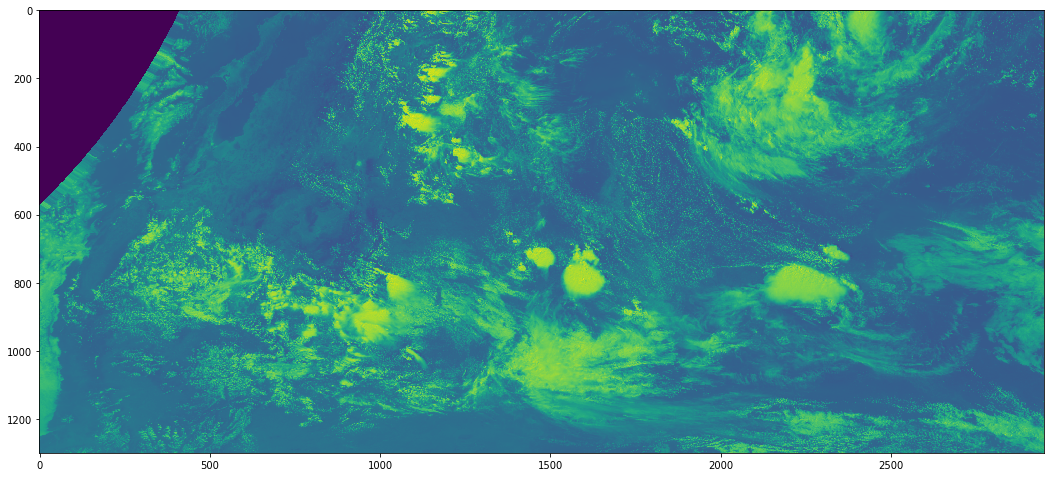

In [7]:
fig, ax = plt.subplots(figsize=(18, 30))
ax.imshow(ref);

Make sure that we get empty array if we ask for a time that doesn't exist

In [8]:
goesio.get_ir_blob_paths(2011, 134, 20)

[]

## Read lightning data
Lightning data is actually just event observations every 20s. So we have to accumulate in a grid

In [9]:
# lightning blobs for 15 minutes as of the IR image
influence_km = 5
irdt = goesio.get_timestamp_from_filename(irblob)
ltg_blobs = goesio.get_ltg_blob_paths(irdt, timespan_minutes=15)
ltg = goesio.create_ltg_grid(ltg_blobs, griddef, influence_km)

8532 events; 8241 events; 7315 events; 9817 events; 8037 events; 10357 events; 7942 events; 7240 events; 7368 events; 7787 events; 8751 events; 7808 events; 8049 events; 8902 events; 8255 events; 8144 events; 9313 events; 7831 events; 8287 events; 6626 events; 7589 events; 10498 events; 7299 events; 6696 events; 8075 events; 9245 events; 9454 events; 7178 events; 7831 events; 7277 events; 8351 events; 8145 events; 7912 events; 9594 events; 8015 events; 7386 events; 7420 events; 7463 events; 6996 events; 7671 events; 8016 events; 8551 events; 8440 events; 7117 events; 9324 events; 

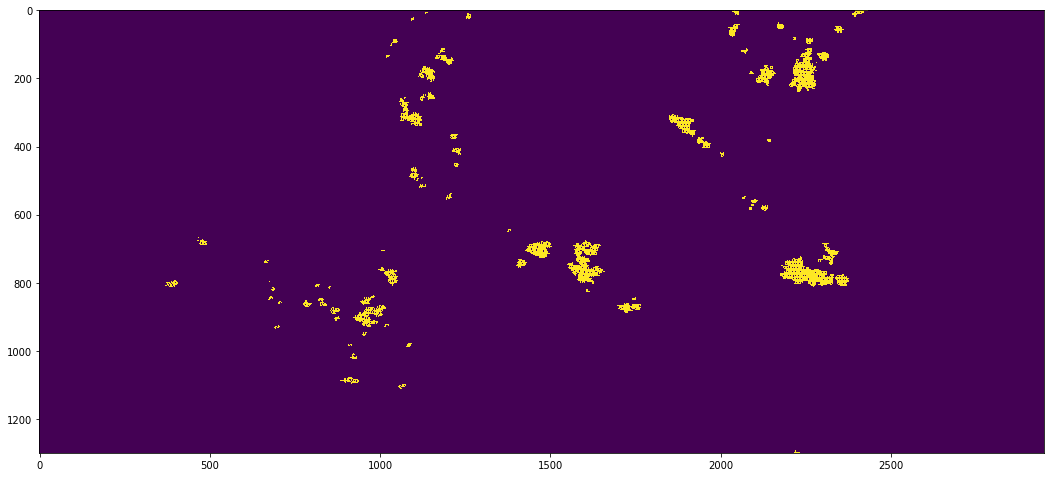

In [10]:
fig, ax = plt.subplots(figsize=(18, 30))
ax.imshow(ltg);

## Relationship between IR and lightning

Mean lightning as the reflectivity threshold is increased

In [11]:
def print_stats(name, data):
  print('{}: shape={}, mean={}, min={}, max={} count={}'.format(name, data.shape, np.mean(data), np.min(data), np.max(data), np.sum(~np.isnan(data))))
  return np.mean(data)

print_stats('ref', ref)
print_stats('ltg for all pixels', ltg)
print_stats('ref for ltg pixels', ref[ltg > 0.5])

ref: shape=(1300, 2950), mean=0.42947593331336975, min=0.0, max=1.0 count=3835000
ltg for all pixels: shape=(1300, 2950), mean=0.012414602346805737, min=0.0, max=1.0 count=3835000
ref for ltg pixels: shape=(47610,), mean=0.7217376828193665, min=0.26106661558151245, max=1.0 count=47610


0.7217377

The average reflectivity associated with all pixels is 0.43 while the reflectivity associated with lightning pixels is 0.72.

In [12]:
frac = []
for thresh in np.arange(0, 1, 0.1):
  frac.append( print_stats('ltg where ref > {}'.format(thresh), ltg[ref > thresh]) )

ltg where ref > 0.0: shape=(3701795,), mean=0.012861328085428825, min=0.0, max=1.0 count=3701795
ltg where ref > 0.1: shape=(3701795,), mean=0.012861328085428825, min=0.0, max=1.0 count=3701795
ltg where ref > 0.2: shape=(3701795,), mean=0.012861328085428825, min=0.0, max=1.0 count=3701795
ltg where ref > 0.30000000000000004: shape=(3438062,), mean=0.013815341317288635, min=0.0, max=1.0 count=3438062
ltg where ref > 0.4: shape=(1704052,), mean=0.02578911911138862, min=0.0, max=1.0 count=1704052
ltg where ref > 0.5: shape=(1070853,), mean=0.03788568552359661, min=0.0, max=1.0 count=1070853
ltg where ref > 0.6000000000000001: shape=(642723,), mean=0.05714125680892079, min=0.0, max=1.0 count=642723
ltg where ref > 0.7000000000000001: shape=(295438,), mean=0.10656381372741489, min=0.0, max=1.0 count=295438
ltg where ref > 0.8: shape=(88084,), mean=0.2616252667907906, min=0.0, max=1.0 count=88084
ltg where ref > 0.9: shape=(3196,), mean=0.5729036295369212, min=0.0, max=1.0 count=3196


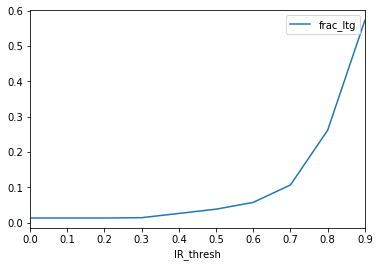

In [13]:
import pandas as pd
df = pd.DataFrame({
  'IR_thresh': np.arange(0,1, 0.1),
  'frac_ltg': frac
})
df.plot('IR_thresh', 'frac_ltg');

How about 30 minutes into the future?

10345 events; 9446 events; 9458 events; 8479 events; 9717 events; 8823 events; 7679 events; 9065 events; 8821 events; 9369 events; 8834 events; 12393 events; 9143 events; 9278 events; 8489 events; 8973 events; 9076 events; 9914 events; 10227 events; 9171 events; 9749 events; 10301 events; 9100 events; 9439 events; 8953 events; 8891 events; 8765 events; 9525 events; 12106 events; 10295 events; 10581 events; 9694 events; 11359 events; 8908 events; 8676 events; 9375 events; 9727 events; 10896 events; 12553 events; 11331 events; 15492 events; 10813 events; 10368 events; 13694 events; 10158 events; ltg where ref > 0.0: shape=(3701795,), mean=0.013786014622635775, min=0.0, max=1.0 count=3701795
ltg where ref > 0.1: shape=(3701795,), mean=0.013786014622635775, min=0.0, max=1.0 count=3701795
ltg where ref > 0.2: shape=(3701795,), mean=0.013786014622635775, min=0.0, max=1.0 count=3701795
ltg where ref > 0.30000000000000004: shape=(3438062,), mean=0.014797871591611786, min=0.0, max=1.0 count=343

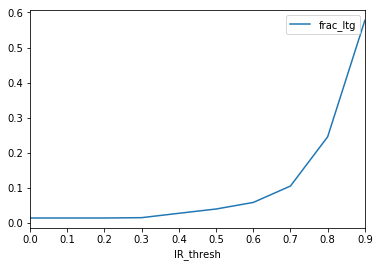

In [14]:
from datetime import timedelta
ltg30_blobs = goesio.get_ltg_blob_paths(irdt + timedelta(minutes=30), timespan_minutes=15)
ltg30 = goesio.create_ltg_grid(ltg30_blobs, griddef, influence_km)
frac = []
for thresh in np.arange(0, 1, 0.1):
  frac.append( print_stats('ltg where ref > {}'.format(thresh), ltg30[ref > thresh]) )
df = pd.DataFrame({
  'IR_thresh': np.arange(0,1, 0.1),
  'frac_ltg': frac
})
df.plot('IR_thresh', 'frac_ltg');

In [15]:
print(griddef.lats)

[[24.   24.   24.   ... 24.   24.   24.  ]
 [24.02 24.02 24.02 ... 24.02 24.02 24.02]
 [24.04 24.04 24.04 ... 24.04 24.04 24.04]
 ...
 [49.94 49.94 49.94 ... 49.94 49.94 49.94]
 [49.96 49.96 49.96 ... 49.96 49.96 49.96]
 [49.98 49.98 49.98 ... 49.98 49.98 49.98]]


Once we get to a reflectivity threshold of 0.9, then 57% of the pixels are associated with lightning.

## Create training examples from IR and lightning

See if there is signal by doing a bit of feature engineering on the ref array and then using scikit-learn

In [16]:
N = 32
strideN = N
halfN = N//2
N15 = N + halfN

def get_prediction_grid_centers(ref): 
  cy, cx = np.meshgrid(np.arange(N15, ref.shape[0]-N15, strideN),
                       np.arange(N15, ref.shape[1]-N15, strideN))
  cy = cy.ravel()
  cx = cx.ravel()
  return zip(cy, cx)

def rawdata_input_fn(ref, ltg, griddef):
  for cy, cx in get_prediction_grid_centers(ref):
    # restrict to grids where there is lightning in the area
    interesting = np.sum(ltg[cy-N15:cy+N15, cx-N15:cx+N15]) > 0.5
    if interesting:
      label = np.sum(ltg[cy-halfN:cy+halfN, cx-halfN:cx+halfN]) > 0.5
      example = {
          'lon': griddef.lons[cy][cx],
          'lat': griddef.lats[cy][cx], 
          'ref_smallbox': ref[cy-halfN:cy+halfN, cx-halfN:cx+halfN],
          'ref_bigbox': ref[cy-N15:cy+N15, cx-N15:cx+N15],
          'has_ltg': label #1.0 if label else 0.0
      }
      yield example

def create_prediction_df(ref, ltg, griddef):
  data = []
  for example in rawdata_input_fn(ref, ltg, griddef):
    data.append([example['lat'],
                 example['lon'],
                 np.mean(example['ref_smallbox']), # mean within subgrid
                 np.max(example['ref_smallbox']),
                 np.mean(example['ref_bigbox']),
                 np.max(example['ref_bigbox']),
                 example['has_ltg']
                ])

  import pandas as pd
  df = pd.DataFrame(data, columns=['lat', 'lon', 'meanref_smallbox', 'maxref_smallbox', 'meanref_bigbox', 'maxref_bigbox', 'ltg'])
  print('For lightning grids {}'.format(df[df['ltg']].describe()))
  print('For no-lightning grids {}'.format(df[~df['ltg']].describe()))
  return df

In [17]:
from sklearn.linear_model import LinearRegression, LogisticRegression
model = LogisticRegression()
df = create_prediction_df(ref, ltg, griddef)
x = df.drop(['lat', 'lon', 'ltg'], axis=1)
model = model.fit(x, df['ltg'] > 0.5)
print(model.coef_, model.intercept_)
print('Model accuracy={}%'.format(100*model.score(x, df['ltg'])))

For lightning grids               lat         lon  meanref_smallbox  maxref_smallbox  \
count  226.000000  226.000000        226.000000       226.000000   
mean    35.514336  -94.979469          0.613720         0.881932   
std      6.086618   11.740588          0.138548         0.059697   
min     24.960000 -117.640000          0.332404         0.609629   
25%     29.440000 -104.840000          0.498058         0.854879   
50%     37.760000  -96.840000          0.614175         0.886846   
75%     40.320000  -82.440000          0.720277         0.918329   
max     46.080000  -77.320000          0.872843         1.000000   

       meanref_bigbox  maxref_bigbox  
count      226.000000     226.000000  
mean         0.582153       0.933181  
std          0.100319       0.033514  
min          0.375210       0.851328  
25%          0.506832       0.909649  
50%          0.577194       0.933441  
75%          0.646450       0.956641  
max          0.811117       1.000000  
For no-lightning

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


We can detect lightning reasonably well based on just the IR temperature.

## Predicting lightning

How about if we try to predict lightning 30 minutes into the future?

In [18]:
from datetime import timedelta

ltg30_blobs = goesio.get_ltg_blob_paths(irdt + timedelta(minutes=30), timespan_minutes=15)
ltg30 = goesio.create_ltg_grid(ltg30_blobs, griddef, influence_km)

model = LogisticRegression()
df = create_prediction_df(ref, ltg30, griddef)
x = df.drop(['lat', 'lon', 'ltg'], axis=1)
model = model.fit(x, df['ltg'])
print(model.coef_, model.intercept_)
print('Model accuracy={}%'.format(100*model.score(x, df['ltg'])))

10345 events; 9446 events; 9458 events; 8479 events; 9717 events; 8823 events; 7679 events; 9065 events; 8821 events; 9369 events; 8834 events; 12393 events; 9143 events; 9278 events; 8489 events; 8973 events; 9076 events; 9914 events; 10227 events; 9171 events; 9749 events; 10301 events; 9100 events; 9439 events; 8953 events; 8891 events; 8765 events; 9525 events; 12106 events; 10295 events; 10581 events; 9694 events; 11359 events; 8908 events; 8676 events; 9375 events; 9727 events; 10896 events; 12553 events; 11331 events; 15492 events; 10813 events; 10368 events; 13694 events; 10158 events; For lightning grids               lat         lon  meanref_smallbox  maxref_smallbox  \
count  256.000000  256.000000        256.000000       256.000000   
mean    35.592500  -95.087500          0.604469         0.874023   
std      6.137973   11.225693          0.139141         0.064274   
min     24.960000 -116.360000          0.332404         0.588439   
25%     30.080000 -104.200000          

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Not bad at all!  We got accuracy of 74% predicting lightning 30 minutes into the future. Of course, this is training & validation on the same hour of data.

## Visualize the prediction

The prediction grid has a resolution that is N times coarser than the original because we were predicting only at the centers (we could always do it at a finer resolution though, by reducing strideN).

In [19]:
df['predicted'] = model.predict_proba(x)[:,0]
df[df['ltg']].describe()

,lat,lon,meanref_smallbox,maxref_smallbox,meanref_bigbox,maxref_bigbox,predicted
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,35.592500,-95.087500,0.604469,0.874023,0.577427,0.929544,0.524425
std,6.137973,11.225693,0.139141,0.064274,0.101274,0.039275,0.118832
min,24.960000,-116.360000,0.332404,0.588439,0.340983,0.690404,0.294532
25%,30.080000,-104.200000,0.489441,0.844352,0.503587,0.907744,0.426192
50%,37.760000,-98.760000,0.598620,0.880971,0.575127,0.933441,0.520323
75%,40.320000,-83.080000,0.707772,0.917858,0.646904,0.956641,0.604284
max,46.720000,-70.280000,0.872843,1.000000,0.811117,1.000000,0.851254


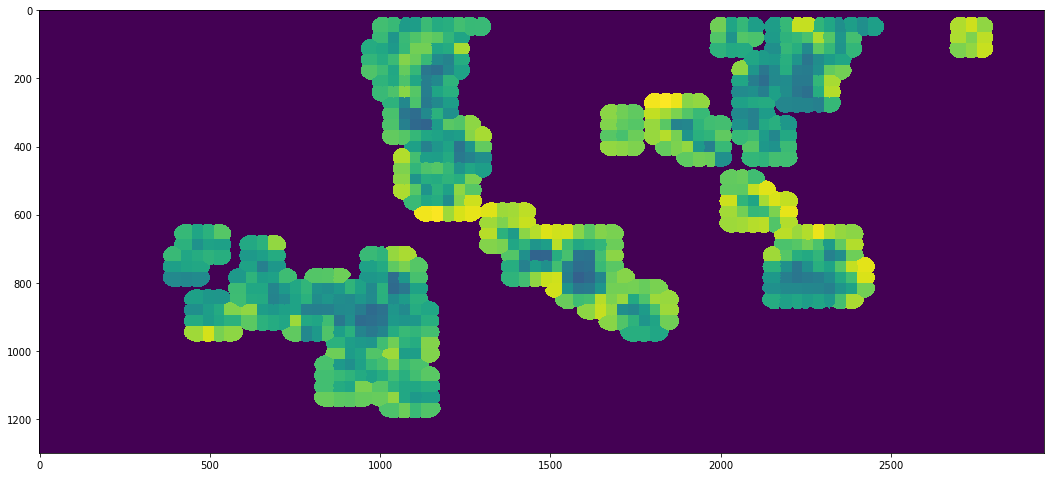

In [20]:
import pyresample as pr
swath_def = pr.geometry.SwathDefinition(lats=df['lat'], lons=df['lon'])
ltgpred = pr.kd_tree.resample_nearest(swath_def, df['predicted'].values, griddef, radius_of_influence=1000*latlonres*100*N, epsilon=0.5)

fig, ax = plt.subplots(figsize=(18, 30))
ax.imshow(ltgpred);

## Beam pipeline to create training dataset

The above was on just one hour of data.  Here's the start of a Beam pipeline that will generate a list of training and evaluation dataset hours. 

In [16]:
import apache_beam as beam
import shutil
import os

def _generate_hours(starthour, endhour, startday, endday, year, is_train):
  for h in range(starthour, endhour+1):
    for d in range(startday, endday+1):
        data = {
          'hour': h,
          'day': d,
          'year': year
        }
        if hash(str(data)) % 10 < 7:
          if is_train:
            yield data
        else:
          if not is_train:
            yield data

def generate_hours(startdate: str, enddate: str, starthour: int, endhour: int, is_train: bool):
    """
    startdate is of form 2018-107
    """
    startyear = int(startdate[:4])
    endyear = int(enddate[:4])
    startday = int(startdate[5:])
    endday = int(enddate[5:])
    if endyear == startyear:
        yield from _generate_hours(starthour, endhour, startday, endday, startyear, is_train)
    else:
        # for startyear, go from startday to day#365
        # FIXME: leap years?
        yield from _generate_hours(starthour, endhour, startday, 365, startyear, is_train)
        for y in range(startyear+1, endyear):
            yield from _generate_hours(starthour, endhour, 1, 365, endyear, is_train)
        yield from _generate_hours(starthour, endhour, 1, endday, endyear, is_train)
            
OUTPUT_DIR = './preproc'
RUNNER = 'DirectRunner'
options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': 'hello',
      'project': 'cloud-training-demos',
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True
}
opts = beam.pipeline.PipelineOptions(flags = [], **options)
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
p = beam.Pipeline(RUNNER, options=opts)

for step in ['train', 'eval']:
  (p 
   | '{}_hours'.format(step) >> beam.Create(generate_hours('2018-183', '2019-184', 12, 14, step == 'train'))
   | '{}_write'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, step)))
  )

job = p.run()
job.wait_until_finish()

'DONE'

In [20]:
!head -3 preproc/eval*
!tail -3 preproc/eval*

{'day': 183, 'year': 2018, 'hour': 12}
{'day': 186, 'year': 2018, 'hour': 12}
{'day': 187, 'year': 2018, 'hour': 12}
{'day': 171, 'year': 2019, 'hour': 14}
{'day': 176, 'year': 2019, 'hour': 14}
{'day': 182, 'year': 2019, 'hour': 14}


Let's invoke the above functions, and put it into our Python module.

In [ ]:
%%bash
python3 -m ltgpred.preproc.create_dataset \
   --outdir=./preproc \
   --startday 2018-183 --endday 2018-183  --starthour 13  --endhour 13 --lightning_validity 2

More beam trials ...

In [23]:
import apache_beam as beam
import datetime
[1, 2, 3] | beam.Map(lambda x : datetime.datetime(2018,x,1))

[datetime.datetime(2018, 1, 1, 0, 0),
 datetime.datetime(2018, 2, 1, 0, 0),
 datetime.datetime(2018, 3, 1, 0, 0)]

In [24]:
import apache_beam as beam
import numpy as np

class MeanStddev(beam.CombineFn):
  def create_accumulator(self):
    return (0.0, 0.0, 0) # x, x^2, count

  def add_input(self, sum_count, input):
    (sum, sumsq, count) = sum_count
    return sum + input, sumsq + input*input, count + 1

  def merge_accumulators(self, accumulators):
    sums, sumsqs, counts = zip(*accumulators)
    return sum(sums), sum(sumsqs), sum(counts)

  def extract_output(self, sum_count):
    (sum, sumsq, count) = sum_count
    if count:
      mean = sum / count
      variance = (sumsq / count) - mean*mean
      # -ve value could happen due to rounding
      stddev = np.sqrt(variance) if variance > 0 else 0
      return {
        'mean': mean,
        'variance': variance,
        'stddev': stddev,
        'count': count
      }
    else:
      return {
        'mean': float('NaN'),
        'variance': float('NaN'),
        'stddev': float('NaN'),
        'count': 0
      }
    
    
#[1.3, 3.0, 4.2] | beam.CombineGlobally(MeanStddev())

#[('a', 1.3), ('a', 3.0), ('b', 4.2)] | beam.CombinePerKey(MeanStddev())

[
  {'a': 1.3, 'b': 2.3, 'c': 4.5},
  {'a': 2.3, 'b': 3.3, 'c': 5.4},  
] | beam.FlatMap(lambda x : [(f, x[f]) for f in ['a', 'b']]) | beam.CombinePerKey(MeanStddev())

[('b',
  {'count': 2,
   'mean': 2.8,
   'stddev': 0.5000000000000009,
   'variance': 0.2500000000000009}),
 ('a',
  {'count': 2,
   'mean': 1.7999999999999998,
   'stddev': 0.5000000000000004,
   'variance': 0.25000000000000044})]

In [27]:
value = np.ma.array([[0.3, 10, 0.8], [-2.8, np.nan, np.inf]], 
                    mask=[[False, True, False], [False, False, False]])
print(value)
x = np.ma.filled(value.flatten(), np.nan)
print(x)
x = np.nan_to_num(x)
print(x)
x = np.clip(x, -1, 1)
print(x)

[[0.3 -- 0.8]
 [-2.8 nan inf]]
[ 0.3  nan  0.8 -2.8  nan  inf]
[ 3.00000000e-001  0.00000000e+000  8.00000000e-001 -2.80000000e+000
  0.00000000e+000  1.79769313e+308]
[ 0.3  0.   0.8 -1.   0.   1. ]


## Run Beam pipeline at scale

Run on all available days in 2018 and 2019.

In [ ]:
%%bash
PROJECT='cloud-training-demos'
BUCKET='cloud-training-demos-ml'
LATLONRES=0.02
TRAIN_RADIUS=32
LABEL_RADIUS=2
STRIDE=4 # use 2*label_patch_radius
OUTDIR=gs://${BUCKET}/lightning/preproc_${LATLONRES}_${TRAIN_RADIUS}_${LABEL_RADIUS}
gsutil -m rm -rf $OUTDIR

python3 -m ltgpred.preproc.create_dataset \
   --outdir=$OUTDIR \
   --startday 2018-45 --endday 2019-111 --project=$PROJECT \
   --train_patch_radius=$TRAIN_RADIUS --label_patch_radius=$LABEL_RADIUS --stride=$STRIDE --latlonres=$LATLONRES

## More data, harder problem

In [ ]:
%%bash
PROJECT='cloud-training-demos'
BUCKET='cloud-training-demos-ml'
LATLONRES=0.02
TRAIN_RADIUS=32
LABEL_RADIUS=1
STRIDE=2 # use 2*label_patch_radius
LTG_VALID_TIME=5
OUTDIR=gs://${BUCKET}/lightning/preproc_${LATLONRES}_${TRAIN_RADIUS}_${LABEL_RADIUS}
gsutil -m rm -rf $OUTDIR

python3 -m ltgpred.preproc.create_dataset \
   --outdir=$OUTDIR \
   --startday 2018-45 --endday 2019-111 --project=$PROJECT \
   --train_patch_radius=$TRAIN_RADIUS --label_patch_radius=$LABEL_RADIUS \
   --stride=$STRIDE --latlonres=$LATLONRES --lightning_validity=$LTG_VALID_TIME

In [33]:
%%bash
gsutil cat gs://cloud-training-demos-ml/lightning/preproc_0.02_32_1/stats*

('ref', {'count': 55453499, 'variance': 0.083776822001068, 'stddev': 0.2894422602196645, 'mean': 0.31534831727030394})
('ltg', {'count': 55453499, 'variance': 0.1928483675611095, 'stddev': 0.439145041599139, 'mean': 0.26093592398921484})


Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the \"License\"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an \"AS IS\" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License